## Predicting airplane delays using Random Forests ##

In this exercise we are going to play a bit with a well known *Big Dataset* about plane trips. This notebook is an adaption of a scala notebook from the spark-notebook project:

[https://github.com/andypetrella/spark-notebook](https://github.com/andypetrella/spark-notebook)

We have translated the notebook to Python and adapted it for the jupyter platform.

### The data ###

For this small example we are going to use a subset of the [*Airline on-time performance*](http://stat-computing.org/dataexpo/2009/) data. For this exercise we will only use the data from the year 2008. This dat is already present in the workshop environment and we only have to load it into spark to get started. Let's explore what we have:

In [1]:
rawData = sc.textFile("2008.csv.gz")

In [2]:
print(rawData.count())

7009729


In [3]:
print type(rawData)
header = rawData.first().split(",")
print header

<class 'pyspark.rdd.RDD'>
[u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime', u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier', u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime', u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance', u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted', u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay', u'LateAircraftDelay']


Let's strip the header and convert each line into an array. We will also make a randomsplit to reduce the amount of data for this notebook:

In [4]:
data = rawData.filter(lambda l: not(l.startswith("Year"))).map(lambda l: l.split(","))
data, rest = data.randomSplit([0.001,0.999], 123456)
print data.count()

6991


In [5]:
print data.take(2)

[[u'2008', u'1', u'3', u'4', u'1849', u'1805', u'2146', u'2110', u'WN', u'1951', u'N674AA', u'117', u'125', u'106', u'36', u'44', u'MDW', u'MHT', u'838', u'4', u'7', u'0', u'', u'0', u'31', u'0', u'0', u'0', u'5'], [u'2008', u'1', u'3', u'4', u'1620', u'1520', u'2144', u'2100', u'WN', u'78', u'N268WN', u'204', u'220', u'189', u'44', u'60', u'OAK', u'HOU', u'1642', u'3', u'12', u'0', u'', u'0', u'14', u'0', u'0', u'0', u'30']]


Let's prettyprint a a row with headers to see the kind of data we have

In [6]:
printSample = data.first()
from IPython.display import display, HTML

th = ["<th>" + d + "</th>" for d in header]
td = ["<td>" + d + "</td>" for d in printSample]

display(HTML("<table><thead><tr>" + "".join(th) + "</tr></thead><tbody><tr>" + "".join(td) + "</tr></tbody></table>"))

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2008,1,3,4,1849,1805,2146,2110,WN,1951,N674AA,117,125,106,36,44,MDW,MHT,838,4,7,0,,0,31,0,0,0,5


A list of airports will probably come in handy. Let's make it. We'll simply use an array index (the airport names are in position 16 and 17) to get a list of distinct airports.

In [7]:
airportsRDD = data.filter(lambda a : (a[16] != "NA" and a[17] != "NA")).flatMap(lambda a : a[16:18]).distinct()
print airportsRDD.count()
print airportsRDD.take(10)
airports = airportsRDD.collect()

272
[u'MCO', u'MTJ', u'TXK', u'MFE', u'ACK', u'SJT', u'AVL', u'MSN', u'HPN', u'GPT']


### More exploration

While we now have a good idea about the structure of the data it's time to delve a little deeper. Let's examine the
distributions of the various delays.

In [8]:
arrDelays = data.filter(lambda a : (a[14] != "NA")).flatMap(lambda a : ((str(a[16]), int(a[14])), (str(a[17]), int(a[14]))))
depDelays = data.filter(lambda a : (a[15] != "NA")).flatMap(lambda a : ((str(a[16]), int(a[15])), (str(a[17]), int(a[15]))))

In [9]:
print arrDelays.take(4)
print depDelays.take(4)

[('MDW', 36), ('MHT', 36), ('OAK', 44), ('HOU', 44)]
[('MDW', 44), ('MHT', 44), ('OAK', 60), ('HOU', 60)]


In order to make histograms we will group delays by airport.

In [10]:
arrDelaysByAirportHist = arrDelays.groupByKey().map(lambda (x,y) : (x, list((y)))) 
depDelaysByAirportHist = depDelays.groupByKey().map(lambda (x,y) : (x, list((y))))

With the delays grouped we can plot some histograms for San Francisco. Note that this can take a while - actual evaluation of the RDD will take place here.

In [11]:
arrDelaysH = arrDelaysByAirportHist.filter(lambda (x,y) : x == "SFO").map(lambda (x,y) : y).collect()
depDelaysH = depDelaysByAirportHist.filter(lambda (x,y) : x == "SFO").map(lambda (x,y) : y).collect()

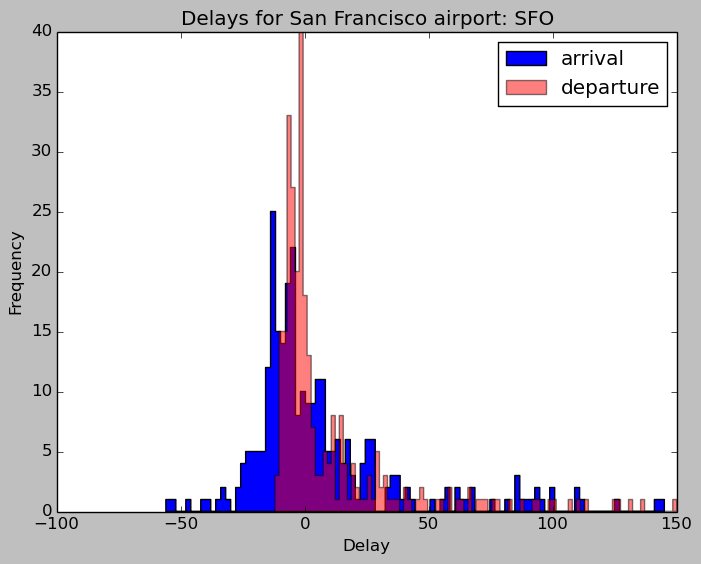

In [12]:
import matplotlib.pyplot as plt

plt.hist(arrDelaysH, bins=100, histtype='stepfilled', color="b", label="arrival")
plt.hist(depDelaysH, bins=100, histtype='stepfilled', color="r", alpha=0.5, label="departure")
plt.title("Delays for San Francisco airport: SFO")
plt.xlabel("Delay")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Machine Learning: Random Forest

Right, now let's apply some machine learning. First import some needed types.

In [13]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import DenseVector

Let's drop some of the categorical features for simplicity. We will label the data with the departure delay and consider the following as features:

In [14]:
features = header[0:8] + header[11:15] + header[16:18] + header[18:21]
print features

[u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime', u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'ActualElapsedTime', u'CRSElapsedTime', u'AirTime', u'ArrDelay', u'Origin', u'Dest', u'Distance', u'TaxiIn', u'TaxiOut']


Now on to the boring (and slightly messy) part:
* clean the data: if a row contains NA, drop it
* convert the airport name to index in airport list for the feature vector
* transform our data to the appropriate MLlib type: *LabeledPoint*

In [15]:
selectedData = data.filter(lambda a: "NA" not in a[0:21]).map(lambda a : 
                                   LabeledPoint(float(a[15]), 
                                   DenseVector([float(x) for x in a[0:8]] + 
                                               [float(x) for x in a[11:15]] + 
                                               [float(airports.index(a[16]))] + 
                                               [float(airports.index(a[17]))] + 
                                               [float(x) for x in a[18:21]]))).cache()

As usual we split this data in training and test sets:

In [16]:
training, testing = selectedData.randomSplit([0.7,0.3], 123456)

After all this work we can finally train the model. Note again that actual evaluation of the training RDD will take place here and can take a few minutes:

In [17]:
categoricalFeaturesInfo = {12:len(airports), 13:len(airports)}
# For actual applications we would typically use much more trees
numTrees = 10
featureSubsetStrategy = "auto"
impurity = "variance"
maxDepth = 4
maxBins = len(airports)

model = RandomForest.trainRegressor(training, categoricalFeaturesInfo, numTrees, featureSubsetStrategy, impurity, maxDepth, maxBins)

Although they are hard to interpret we can take a look at the trained trees:

In [18]:
print "Learned regression forest model:\n" + model.toDebugString()

Learned regression forest model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 11 <= 81.0)
     If (feature 11 <= 28.0)
      If (feature 12 in {119.0,208.0,254.0,258.0,12.0,227.0,250.0,200.0,19.0,28.0,31.0,126.0,234.0,7.0,98.0,165.0,179.0,245.0,259.0,131.0,191.0,223.0,1.0,9.0,253.0,177.0,225.0,264.0,184.0,145.0,10.0,82.0,76.0,182.0,8.0,30.0,229.0,233.0,81.0,147.0,199.0,270.0,124.0,219.0,2.0,94.0,103.0,213.0,65.0,35.0,146.0,24.0,36.0,160.0,185.0,215.0,127.0,92.0,110.0,201.0,46.0,50.0,60.0,100.0,138.0,240.0,69.0,114.0,122.0,206.0,42.0,58.0,96.0,108.0,239.0,246.0,32.0,178.0,109.0,195.0,161.0,59.0,192.0,11.0,106.0,158.0,271.0,51.0,97.0,144.0,83.0,48.0,149.0,224.0,142.0,173.0,23.0,155.0,37.0,205.0,21.0,190.0,125.0,66.0,168.0,181.0,237.0,243.0,162.0,251.0,25.0,120.0,255.0,174.0,198.0,72.0,55.0})
       If (feature 11 <= 3.0)
        Predict: -4.059469350411711
       Else (feature 11 > 3.0)
        Predict: 2.9381443298969074
      Else (feature 12 not in {119.0,208.0

Now let's try to predict some test data:

In [19]:
test = testing.take(10)
predictions = [(point.label, model.predict(point.features), point.label - model.predict(point.features)) for point in test]

from IPython.display import display, HTML
tbody = ""
for tup in predictions:
    tbody = tbody + "<tr><td>" + str(tup[0]) + "</td><td>" + str(tup[1]) + "</td><td>" + str(tup[2]) + "</td></tr>"
display(HTML("<table><thead><tr><th>Actual delay</th><th>Predicted delay</th><th>Difference</th></tr></thead><tbody><tr>" + tbody + "</tr></tbody></table>"))

Actual delay,Predicted delay,Difference
47.0,21.3871475592,25.6128524408
29.0,8.31357438124,20.6864256188
37.0,18.5936325985,18.4063674015
1.0,3.12509322964,-2.12509322964
26.0,14.350545514,11.649454486
0.0,1.44521326625,-1.44521326625
-2.0,2.07383727648,-4.07383727648
-5.0,1.99075251413,-6.99075251413
-2.0,1.4577756571,-3.4577756571
0.0,2.28104054797,-2.28104054797


Now for the MSE. First a baseline and then our model:

In [20]:
# Get some baseline
avgDelay = training.map(lambda p: p.label).mean()
print avgDelay
baseLineData = testing.map(lambda p: (p.label, avgDelay))
print baseLineData.first()
mseBaseLine = baseLineData.map(lambda (x,y) : (x - y)**2).mean()
print mseBaseLine

9.56505342552
(47.0, 9.565053425518544)
1301.66708132


In [21]:
predictions = model.predict(testing.map(lambda p: p.features))
labelsAndPredictions = testing.map(lambda p: p.label).zip(predictions)
print labelsAndPredictions.first()
testMSE = labelsAndPredictions.map(lambda (x,y) : (x - y)**2).mean()
print testMSE

(47.0, 21.387147559225507)
518.970148678


This concludes the notebook. Feel free to experiment more with the model and the data. As an exercise try plotting the predicted and actual values. Alternatively you can try to find out if there are certain airports were the predictions are significantly better. Have fun!